<a href="https://colab.research.google.com/github/oxfordBlueDevil/top_secret_work/blob/main/Mike_Osorio_Galileo_ML_Takehome_Mislabelled_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🌝 🔭 Galileo ML Takehome Challenge -- Mislabeled Detection

Thank you for taking the time to apply! Below you'll find some boilerplate code to load a text classification dataset, train a model over it, and record the model's embeddings and probabilities for each sample.


Your job is then to uncover the mislabeled samples from the training split. Feel free also to change the boiler plate code if you wish!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install -q --upgrade torch torchmetrics transformers s3fs "ipython>=7"

### Loading the Dataset

In [3]:
import pandas as pd

train_path = "s3://galileo-public-tutorial-data/datasets/mltakehome/train.csv"
test_path = "s3://galileo-public-tutorial-data/datasets/mltakehome/test.csv"

train_df = pd.read_csv(train_path).drop("id", axis=1)
test_df = pd.read_csv(test_path).drop("id", axis=1)

print("Training Data")
display(train_df.head())
print(f"Full shape: {train_df.shape}")
print("\n\nTest Data")
display(test_df.head())
print(f"Full shape: {test_df.shape}")

Training Data


,text,label,actual_label
0,How did serfdom develop in and then leave Russ...,DESC,DESC
1,What films featured the character Popeye Doyle ?,ENTY,ENTY
2,How can I find a list of celebrities ' real na...,DESC,DESC
3,What fowl grabs the spotlight after the Chines...,ENTY,ENTY
4,What is the full form of .com ?,ABBR,ABBR


Full shape: (5452, 3)


Test Data


,text,label
0,How far is it from Denver to Aspen ?,NUM
1,"What county is Modesto , California in ?",LOC
2,Who was Galileo ?,HUM
3,What is an atom ?,DESC
4,When did Hawaii become a state ?,NUM


Full shape: (500, 2)


### Creating a Tokenized PyTorch Dataset

In [4]:
import numpy as np
import torch
from transformers import AutoTokenizer
from typing import List


class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self, dataset: pd.DataFrame, split: str, list_of_labels: List[str] = None
    ):
        self.dataset = dataset

        #TODO: put the dataset somewhere for them

        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.encodings = tokenizer(
            self.dataset["text"].tolist(), truncation=True, padding=True
        )

        self.list_of_labels = list_of_labels or self.dataset["label"].unique().tolist()

        self.labels = np.array(
            [self.list_of_labels.index(label) for label in self.dataset["label"]]
        )
        # Add label_idx to original dataframe
        self.dataset["label_idx"] = self.labels
        # Add actual_label_idx to original dataframe
        if split == "train":
            self.dataset["actual_label_idx"] = np.array(
            [self.list_of_labels.index(label) for label in self.dataset["actual_label"]]
        )

    def __getitem__(self, idx):
        x = torch.tensor(self.encodings["input_ids"][idx])
        attention_mask = torch.tensor(self.encodings["attention_mask"][idx])
        y = self.labels[idx]
        return idx, x, attention_mask, y

    def __len__(self):
        return len(self.dataset)

train_dataset = TextDataset(train_df, split="train")
test_dataset = TextDataset(
    test_df,
    split="validation",
    list_of_labels=train_dataset.list_of_labels,
)

labels = train_dataset.list_of_labels

train_model_inputs_and_outputs_df = train_df.to_dict("records")
test_model_inputs_and_outputs_df = test_df.to_dict("records")

### Defining the Model

In [5]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from transformers import AutoModel


class TextClassificationModel(torch.nn.Module):
    """Defines a Pytorch text classification bert based model."""

    def __init__(self, num_labels: int):
        super().__init__()
        self.feature_extractor = AutoModel.from_pretrained("distilbert-base-uncased")
        self.classifier = Linear(self.feature_extractor.config.hidden_size, num_labels)

    def forward(self, x, attention_mask, ids, split):
        """Model forward function."""
        encoded_layers = self.feature_extractor(
            input_ids=x, attention_mask=attention_mask
        ).last_hidden_state
        classification_embedding = encoded_layers[:, 0]
        logits = self.classifier(classification_embedding)

        probs = F.softmax(logits, dim=-1)

        # TODO: Put outputs somewhere
        for batch_idx, df_idx in enumerate(ids.cpu().detach().numpy()):
            if split == "train":
                train_model_inputs_and_outputs_df[df_idx]["embedding"] = classification_embedding[batch_idx].cpu().detach().numpy()
                train_model_inputs_and_outputs_df[df_idx]["probs"] = probs[batch_idx].cpu().detach().numpy()
            elif split == "test":
                test_model_inputs_and_outputs_df[df_idx]["embedding"] = classification_embedding[batch_idx].cpu().detach().numpy()
                test_model_inputs_and_outputs_df[df_idx]["probs"] = probs[batch_idx].cpu().detach().numpy()

        return logits

### Training!


**Note: Make sure your runtime is connected to a GPU.**

In [6]:
import numpy as np
import random
import torch
import torch.nn.functional as F
import torchmetrics
from tqdm.notebook import tqdm

BATCH_SIZE = 32
NUM_EPOCHS = 3

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

model = TextClassificationModel(num_labels=len(train_dataset.list_of_labels))
model.to(device)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5
)

train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=len(labels))
val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=len(labels))

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for data in tqdm(train_dataloader):
        x_idxs, x, attention_mask, y = data
        x = x.to(device)
        attention_mask = attention_mask.to(device)
        y = torch.tensor(y, device=device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        logits = model(x, attention_mask, x_idxs, "train")
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_acc(torch.argmax(logits.to("cpu"), 1), y.to("cpu"))

    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        for val_idx, data in tqdm(enumerate(val_dataloader)):
            x_idxs, x, attention_mask, y = data

            x = x.to(device)
            attention_mask = attention_mask.to(device)
            y = torch.tensor(y, device=device)

            logits = model(x, attention_mask, x_idxs, "test")
            loss = F.cross_entropy(logits, y)

            validation_loss += loss.item()
            val_acc(torch.argmax(logits.to("cpu"), 1), y.to("cpu"))

        print(f"Test accuracy: {val_acc.compute()}")

print("Finished Training")

train_model_inputs_and_outputs_df = pd.DataFrame(train_model_inputs_and_outputs_df)
test_model_inputs_and_outputs_df = pd.DataFrame(test_model_inputs_and_outputs_df)

  0%|          | 0/171 [00:00<?, ?it/s]

<ipython-input-6-46a9b3b8c21c>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, device=device)


0it [00:00, ?it/s]

Test accuracy: 0.949999988079071


<ipython-input-6-46a9b3b8c21c>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, device=device)


  0%|          | 0/171 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Test accuracy: 0.9520000219345093


  0%|          | 0/171 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Test accuracy: 0.9559999704360962
Finished Training


### You're Up!

In [7]:
train_model_inputs_and_outputs_df

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs
0,How did serfdom develop in and then leave Russ...,DESC,DESC,0,0,"[-1.1470404, 0.026504101, -0.22514217, -0.4758...","[0.90293866, 0.046340123, 0.017259978, 0.01014..."
1,What films featured the character Popeye Doyle ?,ENTY,ENTY,1,1,"[0.48053277, -0.5156636, -0.16802923, -0.09346...","[0.009874187, 0.94042593, 0.0052281097, 0.0106..."
2,How can I find a list of celebrities ' real na...,DESC,DESC,0,0,"[-0.5482256, 0.7163675, -0.26258653, -0.438243...","[0.84042466, 0.047984034, 0.03110642, 0.038197..."
3,What fowl grabs the spotlight after the Chines...,ENTY,ENTY,1,1,"[-0.25212473, -1.0941709, -0.12241134, 0.04771...","[0.033052243, 0.8206684, 0.007886911, 0.071470..."
4,What is the full form of .com ?,ABBR,ABBR,2,2,"[0.073927, -0.19951639, 0.9755827, -0.89802194...","[0.27425373, 0.16300455, 0.38139483, 0.1141989..."
...,...,...,...,...,...,...,...
5447,What 's the shape of a camel 's spine ?,ENTY,ENTY,1,1,"[-0.4973158, -0.5457006, 0.74472463, 0.0629193...","[0.29293412, 0.44694963, 0.06553482, 0.0321898..."
5448,What type of currency is used in China ?,DESC,ENTY,0,1,"[0.2551546, -0.76900727, -0.2676006, 0.3079166...","[0.013163064, 0.9399013, 0.008185921, 0.012133..."
5449,What is the temperature today ?,NUM,NUM,5,5,"[-0.116255015, -0.3433011, 1.247631, 0.1797518...","[0.1961972, 0.03249527, 0.041092694, 0.0236177..."
5450,What is the temperature for cooking ?,NUM,NUM,5,5,"[-0.6752546, -0.24269296, 0.98678285, 0.279399...","[0.031083107, 0.021370657, 0.016432473, 0.0178..."


In [8]:
train_model_inputs_and_outputs_df.groupby(['actual_label', 'actual_label_idx']).size()

actual_label  actual_label_idx
ABBR          2                     86
DESC          0                   1162
ENTY          1                   1250
HUM           3                   1223
LOC           4                    835
NUM           5                    896
dtype: int64

In [9]:
# TODO: Detect the mislabeled samples

# Noisy Label Population Analysis

- Let's inspect the number of noisy labels per label. Determine if the noisiness is equally spread across all labels.

In [10]:
train_model_inputs_and_outputs_df.value_counts('label')

label
HUM     1216
ENTY    1214
DESC    1137
NUM      886
LOC      831
ABBR     168
dtype: int64

In [11]:
incorrect_label_mask = train_model_inputs_and_outputs_df['label'] != train_model_inputs_and_outputs_df['actual_label']
train_model_inputs_and_outputs_df['incorrect_label'] = incorrect_label_mask
train_model_inputs_and_outputs_df.groupby('label')['incorrect_label'].sum()

label
ABBR    93
DESC    90
ENTY    92
HUM     97
LOC     87
NUM     86
Name: incorrect_label, dtype: int64

In [12]:
train_model_inputs_and_outputs_df.groupby('label')['incorrect_label'].sum() / train_model_inputs_and_outputs_df.value_counts('label') * 100

label
ABBR    55.357143
DESC     7.915567
ENTY     7.578254
HUM      7.976974
LOC     10.469314
NUM      9.706546
dtype: float64

As we can see, the nosiness is most prevalent in label ABBR where 55.4% of its labels are noisy. LOC and NUM have a similar level of nosiness around 10% while ENTY, HUM, and NUM have a level of nosiness around 7.5 - 8%.

In [13]:
print("Total number of noisy labels: {}".format(train_model_inputs_and_outputs_df['incorrect_label'].sum()))

Total number of noisy labels: 545





# Data Visualiztion of BERT Embeddings of Training Text Data

- We will create a T-SNE plot and mark the BERT embeddings where the assigned label doesn't match the true label with a circle.




In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


# Perform T-SNE dimensionality reduction
train_embeddings = np.vstack(train_model_inputs_and_outputs_df['embedding'].tolist())
tsne = TSNE(n_components=2, random_state=42)
tsne_train_embeddings = tsne.fit_transform(train_embeddings)

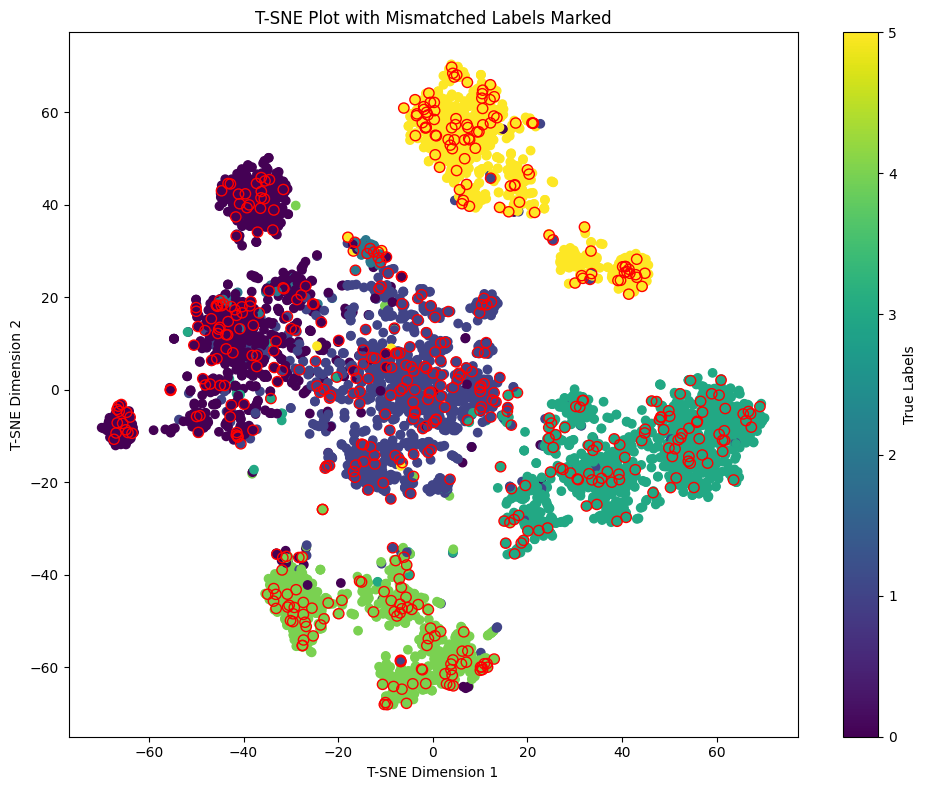

In [15]:
# Create a scatter plot of T-SNE embeddings
assigned_train_labels = train_model_inputs_and_outputs_df['label'].tolist()
true_train_labels = train_model_inputs_and_outputs_df['actual_label'].tolist()
encoded_true_train_labels = train_model_inputs_and_outputs_df['actual_label_idx'].tolist()
plt.figure(figsize=(10, 8))
plt.scatter(tsne_train_embeddings[:, 0], tsne_train_embeddings[:, 1], c=encoded_true_train_labels, cmap='viridis')

# Mark embeddings where assigned label doesn't match true label with a circle
for i in range(len(tsne_train_embeddings)):
    if assigned_train_labels[i] != true_train_labels[i]:
        circle = plt.Circle((tsne_train_embeddings[i, 0], tsne_train_embeddings[i, 1]), 1.1, color='red', fill=False)
        plt.gca().add_artist(circle)

plt.title("T-SNE Plot with Mismatched Labels Marked")
plt.colorbar(label="True Labels")
plt.xlabel("T-SNE Dimension 1")
plt.ylabel("T-SNE Dimension 2")
plt.tight_layout()

Visualization of the embeddings on a T-SNE manfiold helps to show that the noisy labels is are present across all labels. 'DESC' (dark purple), 'ENTY' (blue purple), and 'ABBR' (teal blue) are clustered very closely to each other. There is a bit overlap between 'ENTY' (blue purple) and 'HUM' (teal green) clusters. The label clusters 'LOC' (light green) and 'NUM' (yellow) don't have overlap with the other label clusters.

### Calculate Embedding-Based Similarity:
- Calculate the pairwise cosine similarity or Euclidean distance between BERT embeddings. This will create a similarity matrix or distance matrix for your dataset.


In [16]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_embedding_cosine_similarity_matrix(embeddings: np.array) -> np.array:
  cosine_sim_matrix = cosine_similarity(embeddings)
  return cosine_sim_matrix

#### An All Labels at Once Approach for Identifying Noisy Labels

We calculate similarity scores for the entire training dataset so we can visualize the average cosine similarity for each embedding in the dataset. This can help us determine a threshold value for the similarity score. This threshold will determine how similar or dissimilar the embeddings need to be to consider samples as noisy or not.

In [17]:
cosine_sim_matrix_train_embeddings = compute_embedding_cosine_similarity_matrix(train_embeddings)
avg_cosine_sim_train_embeddings = np.average(cosine_sim_matrix_train_embeddings, axis=1)

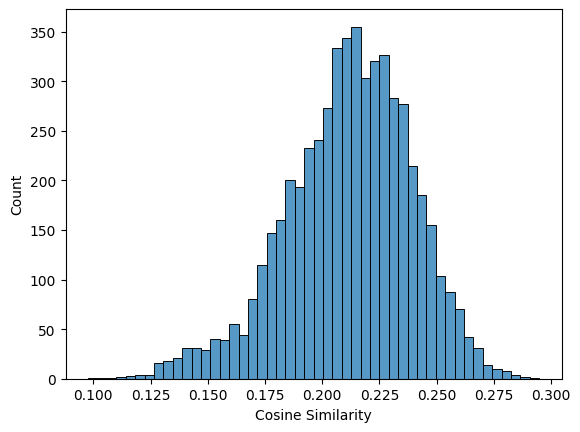

In [18]:
import seaborn as sns

sns.histplot(avg_cosine_sim_train_embeddings)
_ = plt.xlabel('Cosine Similarity')

Distribution of the cosine similariy score is a bit bimodal. We can try to gauge a good threshold by trying a value along the left trail of the first mode. These are values around 0.2 or less.

In [23]:
(avg_cosine_sim_train_embeddings < 0.1765).sum()

555

Review a sample to see if we identify noisy labels at this threshold.

In [24]:
potential_noisy_sample_df = train_model_inputs_and_outputs_df[avg_cosine_sim_train_embeddings < 0.1765]
potential_noisy_sample_df.head(30)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
10,When was Ozzy Osbourne born ?,NUM,NUM,5,5,"[-0.8323694, -0.43473452, 0.95855093, -0.70877...","[0.04991912, 0.042215463, 0.0118576735, 0.0189...",False
20,What is the date of Boxing Day ?,NUM,NUM,5,5,"[-0.17114896, 0.3483892, 1.3148273, -0.3020019...","[0.014355561, 0.014601088, 0.005737522, 0.0138...",False
25,What 's the second-most-used vowel in English ?,ENTY,ENTY,1,1,"[-0.21290027, -0.04098681, 0.3307423, 0.075028...","[0.057446875, 0.7158634, 0.1061489, 0.03173386...",False
30,What does the abbreviation AIDS stand for ?,ABBR,ABBR,2,2,"[0.55938077, 0.56035703, 0.20265374, 0.0229082...","[0.06450626, 0.050348032, 0.7984866, 0.0296252...",False
36,When did the neanderthal man live ?,NUM,NUM,5,5,"[-0.49436507, -0.41680625, 0.58592844, -0.1738...","[0.024101214, 0.022034517, 0.018201912, 0.0174...",False
43,How many inches over six feet is the Venus de ...,NUM,NUM,5,5,"[-0.544135, 0.007934497, -0.118163064, -0.0514...","[0.019092677, 0.028744107, 0.008281036, 0.0161...",False
65,Which city has the oldest relationship as a si...,LOC,LOC,4,4,"[0.51184547, 0.10277123, -0.1432793, 0.228806,...","[0.016623404, 0.04631641, 0.031095758, 0.20987...",False
89,In which year was New Zealand excluded from th...,NUM,NUM,5,5,"[-0.523942, 0.5556359, 1.0964606, -0.23674549,...","[0.013301824, 0.021667792, 0.013818346, 0.0177...",False
90,When did CNN begin broadcasting ?,NUM,NUM,5,5,"[-0.4531139, -0.5480024, 1.2319483, -0.5345568...","[0.03112323, 0.011058395, 0.015271909, 0.01847...",False
98,When did Rococo painting and architecture flou...,NUM,NUM,5,5,"[-0.38131192, -0.44174382, 0.76310736, -0.1665...","[0.06396167, 0.040388875, 0.013560969, 0.02138...",False


There are some noisy labels in the sample but not as many we would like. Let's try a lower threshold like 0.15.

In [25]:
potential_noisy_sample_df = train_model_inputs_and_outputs_df[avg_cosine_sim_train_embeddings < 0.15]
potential_noisy_sample_df.head(30)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
20,What is the date of Boxing Day ?,NUM,NUM,5,5,"[-0.17114896, 0.3483892, 1.3148273, -0.3020019...","[0.014355561, 0.014601088, 0.005737522, 0.0138...",False
30,What does the abbreviation AIDS stand for ?,ABBR,ABBR,2,2,"[0.55938077, 0.56035703, 0.20265374, 0.0229082...","[0.06450626, 0.050348032, 0.7984866, 0.0296252...",False
36,When did the neanderthal man live ?,NUM,NUM,5,5,"[-0.49436507, -0.41680625, 0.58592844, -0.1738...","[0.024101214, 0.022034517, 0.018201912, 0.0174...",False
43,How many inches over six feet is the Venus de ...,NUM,NUM,5,5,"[-0.544135, 0.007934497, -0.118163064, -0.0514...","[0.019092677, 0.028744107, 0.008281036, 0.0161...",False
89,In which year was New Zealand excluded from th...,NUM,NUM,5,5,"[-0.523942, 0.5556359, 1.0964606, -0.23674549,...","[0.013301824, 0.021667792, 0.013818346, 0.0177...",False
90,When did CNN begin broadcasting ?,NUM,NUM,5,5,"[-0.4531139, -0.5480024, 1.2319483, -0.5345568...","[0.03112323, 0.011058395, 0.015271909, 0.01847...",False
129,When did the Bounty mutiny take place ?,NUM,NUM,5,5,"[-0.3268851, -0.5570942, 1.6658008, -0.3029167...","[0.020484408, 0.016666325, 0.009363808, 0.0159...",False
168,In what year did Thatcher become prime minister ?,NUM,NUM,5,5,"[-0.8368763, 0.03483562, 0.95780146, -0.300620...","[0.008510992, 0.009873008, 0.0047425046, 0.008...",False
203,When did the royal wedding of Prince Andrew an...,NUM,NUM,5,5,"[-0.5247785, -0.35243526, 1.1106491, -0.480694...","[0.015729582, 0.013775588, 0.009069118, 0.0235...",False
221,What does S.O.S. stand for ?,ENTY,ABBR,1,2,"[1.0165453, 0.31791934, 0.53474593, -0.0932949...","[0.04794343, 0.038034614, 0.8433342, 0.0274038...",True


Our All Labels at Once approach doesn't look too promising for identifying noisy labels. We are marking a high numbers of examples as noisy which are labeled correctly. Let's see if another approach could be better than this.

Since mentioned in the label population analysis, we noticed that the nosiness vary significantly across different labels. It may be wise to focus our noisy label identification efforts on labels independently. This may be more effective at pinpointing noisy labels.

#### A Per Label Approach For Noisy Samples

We will perform label-specific analysis separately for each label in our multi-label classification problem by calculating similarity scores for each label sample independently.

We will conduct the following per label:
- For each sample in your dataset, calculate its similarity or distance score with all other samples with the same label.
- If the similarity or distance score of a sample with other samples exceeds the defined threshold, mark it as potentially noisy.

In [26]:
assigned_train_labels_np = train_model_inputs_and_outputs_df['label'].to_numpy()
true_train_labels_np = train_model_inputs_and_outputs_df['actual_label'].to_numpy()

In [27]:
def embedding_based_similarity_histogram(embedding_similarities: np.array, label_for_analysis: str):
  sns.histplot(embedding_similarities)
  _ = plt.xlabel('Cosine Similarity')
  _ = plt.ylabel('{} Label Count'.format(label_for_analysis))

def embedding_based_similarity_analysis_by_label(embeddings: np.array, labels: np.array, label_for_analysis: str, hist_plot: bool = False) -> np.array:
  cosine_sim_matrix_by_label_embeddings = compute_embedding_cosine_similarity_matrix(embeddings[labels == label_for_analysis])
  avg_cosine_sim_by_label_embeddings = np.average(cosine_sim_matrix_by_label_embeddings, axis=1)

  if hist_plot:
    embedding_based_similarity_histogram(avg_cosine_sim_by_label_embeddings, label_for_analysis)

  return avg_cosine_sim_by_label_embeddings

#### 'ABBR' Similarity Score Analysis to Identify Noisy Examples

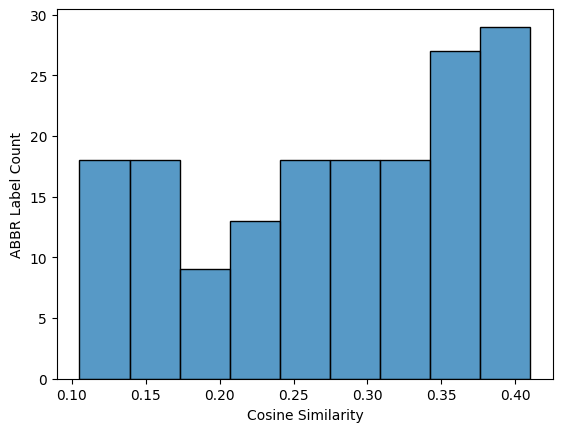

In [28]:
avg_cosine_sim_abbr_train_embeddings = embedding_based_similarity_analysis_by_label(train_embeddings, assigned_train_labels_np, 'ABBR', hist_plot=True)

In [31]:
(avg_cosine_sim_abbr_train_embeddings < 0.31).sum()

95

Let's review a sample of ABBR examples to see if we can identify noisy ones by setting a threshold on the similarity score of our ABBR sample of cosine similarity scores.

In [32]:
def get_noisy_sample_for_label(df: pd.DataFrame, embedding_similarities: np.array, label_for_analysis: str, threshold_similarity: float) -> pd.DataFrame:
  label_mask = df['label'] == label_for_analysis
  label_df = df[label_mask]
  potential_noisy_mask = embedding_similarities < threshold_similarity
  potential_noisy_sample_df = label_df[potential_noisy_mask]
  return potential_noisy_sample_df

In [33]:
potential_noisy_sample_abbr = get_noisy_sample_for_label(train_model_inputs_and_outputs_df, avg_cosine_sim_abbr_train_embeddings, 'ABBR', 0.31)
potential_noisy_sample_abbr.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
39,What relative of the racoon is sometimes known...,ABBR,ENTY,2,1,"[-0.28827932, -0.24717143, 0.3228216, -0.38992...","[0.06786735, 0.3044054, 0.051885817, 0.4423179...",True
80,What is Nebraska 's most valuable resource ?,ABBR,ENTY,2,1,"[-0.5298237, -0.8025991, 0.017591847, -0.08028...","[0.09972601, 0.6471587, 0.0425849, 0.03314887,...",True
136,What actress has received the most Oscar nomin...,ABBR,HUM,2,3,"[0.09720943, 0.053888675, -0.14358455, -0.8357...","[0.00863987, 0.028703619, 0.01972868, 0.919577...",True
264,What is a Canada two-penny black ?,ABBR,DESC,2,0,"[-0.7311588, -0.08708643, 0.26660052, -0.67181...","[0.90796316, 0.018622138, 0.037897546, 0.00453...",True
272,What color bottles do good Rhine wines come in ?,ABBR,ENTY,2,1,"[0.4410094, -0.57815313, 0.17188811, 0.2065762...","[0.032686096, 0.84207433, 0.03972509, 0.023322...",True
424,What are some interesting facts and informatio...,ABBR,DESC,2,0,"[-0.3943407, -0.19145067, 0.32522586, 0.111241...","[0.46927065, 0.37745047, 0.038867522, 0.030181...",True
490,What was the first Lifesaver flavor ?,ABBR,ENTY,2,1,"[-0.35053214, -0.7935808, -0.17509012, 0.40160...","[0.019714633, 0.9240856, 0.013330558, 0.012834...",True
658,What is the Motto for the State of Maryland ?,ABBR,DESC,2,0,"[1.0413178, -0.34981927, -0.21560533, -0.24088...","[0.10410349, 0.4930584, 0.14304397, 0.10667971...",True
762,How do I start a bank ?,ABBR,DESC,2,0,"[-0.28982306, 0.59404814, 0.015272442, -0.0293...","[0.93703353, 0.02231764, 0.013487981, 0.010439...",True
768,What former major-league left-handed baseball ...,ABBR,HUM,2,3,"[0.6690858, -0.0999919, -0.3311546, -0.604802,...","[0.008159704, 0.016259558, 0.014261493, 0.9420...",True


In [34]:
potential_noisy_sample_abbr.tail(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4327,How old was Stevie Wonder when he signed with ...,ABBR,NUM,2,5,"[-0.63012236, 0.33948752, 0.2170342, -0.171420...","[0.0186994, 0.036891177, 0.008914636, 0.051107...",True
4347,What is LMDS ?,ABBR,ABBR,2,2,"[-0.7449709, -0.07466796, 0.484887, -0.5302669...","[0.7953398, 0.027754713, 0.084975146, 0.032668...",False
4352,How do you get a pointsettia to turn red ?,ABBR,DESC,2,0,"[-1.2781016, 0.28667426, 0.34733197, -1.070715...","[0.9299678, 0.031131042, 0.01205901, 0.0104378...",True
4369,How can I get in touch with Michael Moore of `...,ABBR,DESC,2,0,"[-0.573789, 0.9095985, -0.110867724, -0.727871...","[0.93673843, 0.01916464, 0.0111149615, 0.01387...",True
4476,What will the weather be today ?,ABBR,DESC,2,0,"[-0.17427352, -0.38907823, 1.3788608, -0.20623...","[0.321919, 0.12154043, 0.036977176, 0.03474146...",True
4504,When did Jaco Pastorius die ?,ABBR,NUM,2,5,"[-0.47345424, -0.4083567, 0.7385462, -0.239622...","[0.016368791, 0.019134544, 0.0062290705, 0.004...",True
4569,What is osmosis ?,ABBR,DESC,2,0,"[-0.46375054, 0.14485478, 0.03700293, -0.50242...","[0.8821454, 0.027516961, 0.04604502, 0.0150482...",True
4638,Who was considered to be the father of psychol...,ABBR,HUM,2,3,"[-0.27884686, 0.5234322, -0.7214315, -0.009109...","[0.023538157, 0.015586872, 0.02298535, 0.89556...",True
4811,What 's Mrs. Bridges 's job on TV 's Upstairs ...,ABBR,HUM,2,3,"[0.29373232, -0.17026466, 0.5249301, -0.234406...","[0.070934065, 0.11547531, 0.024881195, 0.64824...",True
4818,What do river otters eat ?,ABBR,ENTY,2,1,"[-0.58327705, -0.12915793, -1.0224358, 0.44281...","[0.11126415, 0.76215327, 0.024609722, 0.034426...",True


The similarity treshold we set is identifying a high number incorrectly marked labels for our 'ABBR' sample :)

#### 'DESC' Similarity Score Analysis to Identify Noisy Examples

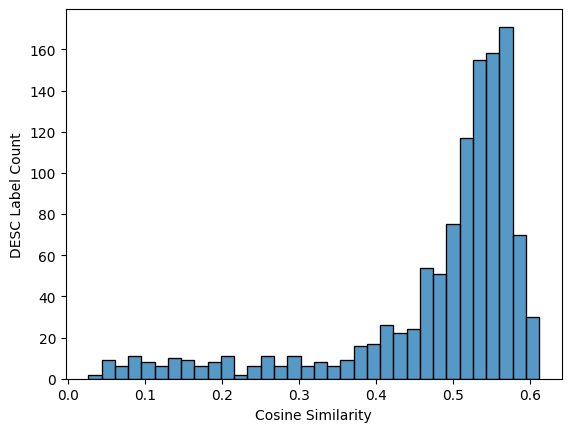

In [35]:
avg_cosine_sim_desc_train_embeddings = embedding_based_similarity_analysis_by_label(train_embeddings, assigned_train_labels_np, 'DESC', hist_plot=True)

In [41]:
(avg_cosine_sim_desc_train_embeddings < 0.24).sum()

90

Let's review a sample of DESC examples to see if we can identify noisy ones by setting a threshold on the similarity score of our DESC sample of cosine similarity scores.

In [42]:
potential_noisy_sample_desc = get_noisy_sample_for_label(train_model_inputs_and_outputs_df, avg_cosine_sim_desc_train_embeddings, 'DESC', 0.24)
potential_noisy_sample_desc.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
29,Which two states enclose Chesapeake Bay ?,DESC,LOC,0,4,"[-0.08608045, -0.42310375, 0.68745136, -0.1892...","[0.03175584, 0.052068625, 0.02243749, 0.129997...",True
110,Where do chihuahuas come from ?,DESC,DESC,0,0,"[-0.055694863, -0.19402769, -0.0039362866, -0....","[0.10131181, 0.03933968, 0.017206207, 0.011944...",False
158,"What poem contains the line , `` grow old with...",DESC,ENTY,0,1,"[-0.3422438, -0.7653548, -0.7783254, -0.383031...","[0.08915439, 0.7832691, 0.023097198, 0.0221825...",True
218,What shrubs can be planted that will be safe f...,DESC,ENTY,0,1,"[0.25435123, -0.29952395, 0.33747151, -0.45361...","[0.082897305, 0.46782988, 0.020895252, 0.09331...",True
303,Which Doonesbury character was likely to turn ...,DESC,HUM,0,3,"[-0.13704313, -0.469452, 0.09623181, 0.3563267...","[0.05063232, 0.1904383, 0.014108534, 0.7102371...",True
310,What stadium do the Miami Dolphins play their ...,DESC,LOC,0,4,"[0.85498405, -0.0031502543, 0.17925625, 0.6773...","[0.027076084, 0.26230174, 0.019030176, 0.21632...",True
327,Where can I find a `` Fifth Element '' screens...,DESC,LOC,0,4,"[0.005434191, 0.13167098, -0.1536812, -0.62956...","[0.076948576, 0.021810556, 0.01852844, 0.01789...",True
334,Hazmat stands for what ?,DESC,DESC,0,0,"[1.2525557, 0.1511285, -0.50840604, -0.3803596...","[0.1429514, 0.43475243, 0.23867553, 0.08946372...",False
335,What creature scares people in the film `` Jaw...,DESC,ENTY,0,1,"[0.15759498, -0.44619843, -0.8891474, 0.197379...","[0.028691355, 0.9099303, 0.007706031, 0.020189...",True
442,How much snow equals an inch of rain ?,DESC,NUM,0,5,"[-0.25590184, 0.1503967, -0.073994175, -0.0592...","[0.018243346, 0.015232581, 0.006096897, 0.0099...",True


In [43]:
potential_noisy_sample_desc.tail(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4201,What was Mae West 's last film ?,DESC,ENTY,0,1,"[-0.32048443, -1.1771929, -0.31317624, -0.0717...","[0.024317045, 0.9081228, 0.006174236, 0.020811...",True
4253,Where can I find info on Alexander Mackenzie ?,DESC,LOC,0,4,"[-0.023426564, -0.45986608, -0.37304884, -0.15...","[0.048537113, 0.04712734, 0.019986931, 0.01253...",True
4304,"What was Mao , the Chinese leader 's , full na...",DESC,HUM,0,3,"[-0.4702699, 0.17037764, -0.10297368, -0.37327...","[0.022688972, 0.02453522, 0.019191964, 0.89394...",True
4367,What are the capital cities of the two large c...,DESC,LOC,0,4,"[-0.4912956, -0.3177191, -0.061530694, -0.6904...","[0.026019251, 0.019063033, 0.0071791904, 0.043...",True
4431,How many colors are there in a rainbow ?,DESC,NUM,0,5,"[-0.5578741, -0.16283628, 0.4030271, 0.1501211...","[0.0176944, 0.014870654, 0.0077367877, 0.01001...",True
4514,Colin Powell is best known for what achievement ?,DESC,DESC,0,0,"[-0.07842338, 0.21898851, -0.012597292, -0.299...","[0.13374472, 0.2248682, 0.044808708, 0.3701668...",False
4540,How many people died when the Estonia sank in ...,DESC,NUM,0,5,"[-0.71874535, -0.069317795, -0.22799331, -0.04...","[0.021493157, 0.019188931, 0.008621126, 0.0291...",True
4546,Where did the name root beer come from ?,DESC,DESC,0,0,"[0.3108755, -0.4261925, -0.38286132, -0.374497...","[0.0769729, 0.087059714, 0.033782285, 0.020254...",False
4555,What 's the state motto of California ?,DESC,DESC,0,0,"[0.9104649, -0.1662644, -0.12835853, -0.037238...","[0.12579434, 0.58039016, 0.050136, 0.09914094,...",False
4591,What 's the motto of the Boy Scouts ?,DESC,DESC,0,0,"[0.67350155, -0.48101878, 0.1585881, 0.4137101...","[0.06962706, 0.77647376, 0.072196625, 0.040708...",False


The similarity treshold we set is identifying a high number incorrectly marked labels for our 'DESC' sample :)

#### 'ENTY' Similarity Score Analysis to Identify Noisy Examples

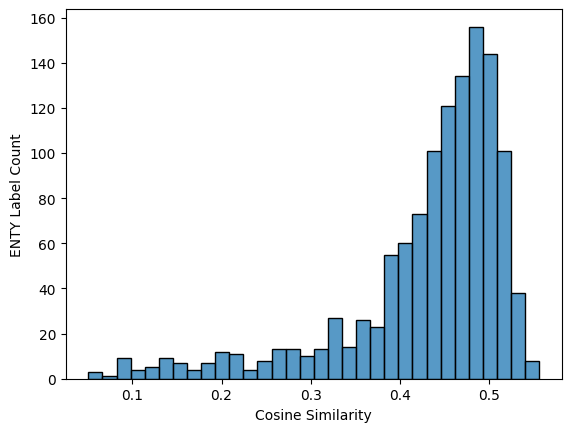

In [44]:
avg_cosine_sim_enty_train_embeddings = embedding_based_similarity_analysis_by_label(train_embeddings, assigned_train_labels_np, 'ENTY', hist_plot=True)

In [48]:
(avg_cosine_sim_enty_train_embeddings < 0.265).sum()

93

Let's review a sample of ENTY examples to see if we can identify noisy ones by setting a threshold on the similarity score of our ENTY sample of cosine similarity scores.

In [49]:
potential_noisy_sample_enty = get_noisy_sample_for_label(train_model_inputs_and_outputs_df, avg_cosine_sim_enty_train_embeddings, 'ENTY', 0.265)
potential_noisy_sample_enty.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
58,What U.S. state lived under six flags ?,ENTY,LOC,1,4,"[-0.19750294, -1.0054313, 0.12298844, -0.46345...","[0.010597674, 0.03594731, 0.0113803735, 0.1038...",True
64,Who do Herb and Tootsie live next door to ?,ENTY,HUM,1,3,"[0.55685884, 0.5010741, 0.1555125, -0.975122, ...","[0.016624924, 0.013351344, 0.017278818, 0.9243...",True
66,What is a caldera ?,ENTY,DESC,1,0,"[-0.7637394, 0.00907571, 0.6396744, -0.7401673...","[0.86157805, 0.021324769, 0.04288714, 0.013918...",True
184,Why do horseshoes bring luck ?,ENTY,DESC,1,0,"[-0.6984156, 0.81987345, -0.432568, -0.7311913...","[0.9415463, 0.017405674, 0.010581619, 0.009938...",True
221,What does S.O.S. stand for ?,ENTY,ABBR,1,2,"[1.0165453, 0.31791934, 0.53474593, -0.0932949...","[0.04794343, 0.038034614, 0.8433342, 0.0274038...",True
339,Who was the first woman golfer to earn a milli...,ENTY,HUM,1,3,"[-0.023478711, -0.008212588, -0.3599825, -0.25...","[0.01535803, 0.017332947, 0.012075913, 0.91859...",True
350,Who is the man behind the pig-the man who pull...,ENTY,HUM,1,3,"[-0.2587019, 0.22271429, -0.7589029, 0.4061093...","[0.0129410075, 0.008393541, 0.008702796, 0.949...",True
461,Where does your hair grow the fastest ?,ENTY,ENTY,1,1,"[-0.6614352, -0.7831622, 0.51222104, -0.811784...","[0.040456515, 0.035699632, 0.011559927, 0.0080...",False
502,What was known as the Spice Island ?,ENTY,LOC,1,4,"[-0.14164549, -1.1214008, -0.14634177, -1.2347...","[0.07273937, 0.07217367, 0.01353948, 0.0155899...",True
566,What is a green bog ?,ENTY,DESC,1,0,"[-0.4583331, -0.122035325, 0.101931185, -0.426...","[0.8574981, 0.056354504, 0.036159836, 0.012939...",True


In [51]:
potential_noisy_sample_enty.tail(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4264,"Who manufactures the software , `` PhotoShop '' ?",ENTY,HUM,1,3,"[0.21269017, 0.22443455, -0.31391162, -0.14805...","[0.008375479, 0.008517773, 0.018210068, 0.9376...",True
4326,What is the Homelite Inc. home page ?,ENTY,LOC,1,4,"[-0.7319141, -0.53202516, 0.100697905, -0.7343...","[0.26825508, 0.19116563, 0.078641005, 0.183760...",True
4441,When was Babe Ruth born ?,ENTY,NUM,1,5,"[-0.30205515, -0.25892743, 0.6419852, -0.52185...","[0.011670732, 0.017817188, 0.008806066, 0.0133...",True
4524,What 's the American dollar equivalent for 8 p...,ENTY,NUM,1,5,"[-0.72317857, 0.1631028, -0.30914202, -0.06633...","[0.045108065, 0.117405064, 0.015395395, 0.0276...",True
4551,Who was the first animal into space ?,ENTY,ENTY,1,1,"[-0.11047481, 0.21678905, 0.03911034, 0.018409...","[0.016304554, 0.030711612, 0.024956884, 0.8764...",False
4584,What kind of sports team is the Buffalo Sabres ?,ENTY,ENTY,1,1,"[0.3808293, -0.18468885, 0.6823143, -0.0588309...","[0.023925891, 0.059398096, 0.011732218, 0.8741...",False
4625,Who were John F. Kennedy 's dogs ?,ENTY,ENTY,1,1,"[0.2960592, 0.42356154, -0.1784679, -0.4647687...","[0.006866959, 0.007425781, 0.008951326, 0.9583...",False
4708,What Japanese city was once called Edo ?,ENTY,LOC,1,4,"[-0.90983707, -0.7156901, -0.083004676, -0.560...","[0.015502522, 0.02816978, 0.009625197, 0.02982...",True
4745,What line divided the North and South in the U...,ENTY,ENTY,1,1,"[-0.3342606, -0.84633577, 0.082998596, -0.5480...","[0.17094328, 0.21017197, 0.048138697, 0.139509...",False
4822,What five-time winner of the Kentucky Derby lo...,ENTY,ENTY,1,1,"[-0.25113994, -1.1272805, -0.596604, -0.003524...","[0.042240255, 0.22459322, 0.041311108, 0.58710...",False


The similarity treshold we set is identifying a high number incorrectly marked labels for our 'ENTY' sample :)

#### 'HUM' Similarity Score Analysis to Identify Noisy Examples

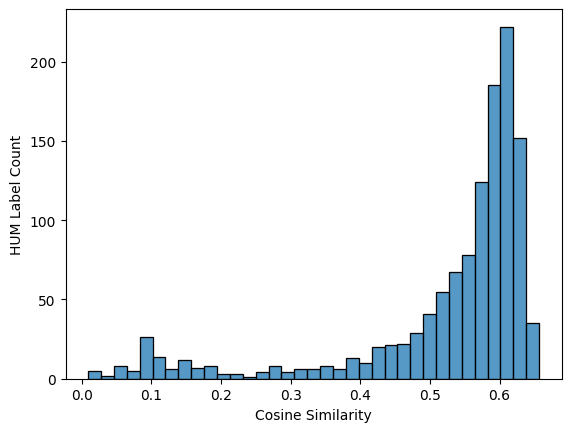

In [52]:
avg_cosine_sim_hum_train_embeddings = embedding_based_similarity_analysis_by_label(train_embeddings, assigned_train_labels_np, 'HUM', hist_plot=True)

In [58]:
(avg_cosine_sim_hum_train_embeddings < 0.22).sum()

97

Let's review a sample of HUM examples to see if we can identify noisy ones by setting a threshold on the similarity score of our HUM sample of cosine similarity scores.

In [59]:
potential_noisy_sample_hum = get_noisy_sample_for_label(train_model_inputs_and_outputs_df, avg_cosine_sim_hum_train_embeddings, 'HUM', 0.22)
potential_noisy_sample_hum.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
47,What ISPs exist in the Caribbean ?,HUM,HUM,3,3,"[0.12477454, -0.17516504, -0.20946446, -0.7678...","[0.5832333, 0.23486756, 0.08695357, 0.0406182,...",False
70,What body of water does the Danube River flow ...,HUM,LOC,3,4,"[-0.21115622, -0.5660044, -0.2330128, -0.58334...","[0.037501793, 0.03037208, 0.01307052, 0.012637...",True
75,How do I make fuel bricks from recycled newspa...,HUM,DESC,3,0,"[-0.85241807, 0.4157686, -0.28547427, -0.63665...","[0.94678307, 0.023516139, 0.010515523, 0.00720...",True
85,How many villi are found in the small intestine ?,HUM,NUM,3,5,"[-0.04827197, -0.09013653, -0.3682341, 0.08457...","[0.03182105, 0.016264182, 0.008617033, 0.01404...",True
87,What is a fear of shadows ?,HUM,ENTY,3,1,"[-0.017484691, -0.7542574, -0.29624632, -0.680...","[0.02907491, 0.9306258, 0.0071064387, 0.009015...",True
265,What European city do Nicois live in ?,HUM,LOC,3,4,"[-0.09129757, -0.57344043, -0.30571657, -0.072...","[0.015522829, 0.02534203, 0.0073513957, 0.0357...",True
279,When was the battle of the Somme fought ?,HUM,NUM,3,5,"[-0.8553093, -0.5526962, 1.3760191, -0.9137274...","[0.024620647, 0.027510645, 0.009064351, 0.0177...",True
409,What golfing accessory was patented by George ...,HUM,ENTY,3,1,"[-0.47042564, -0.6013716, 0.2902799, 0.0899474...","[0.06905153, 0.7606946, 0.01360524, 0.06598639...",True
441,How many miles is it to Ohio from North Caroli...,HUM,NUM,3,5,"[-0.59740126, 0.36212784, 0.2167452, 0.0298954...","[0.042825196, 0.019146679, 0.01360905, 0.03185...",True
563,What is the temperature for baking Peachy Oat ...,HUM,NUM,3,5,"[-0.4917596, 0.12598999, 0.8795464, -0.1112613...","[0.02705389, 0.023969071, 0.016748533, 0.01905...",True


In [60]:
potential_noisy_sample_hum.tail(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4333,What are the four railways in Monopoly ?,HUM,HUM,3,3,"[0.14574231, -0.46934444, 0.3484796, -0.423894...","[0.058451913, 0.11807673, 0.018168489, 0.11795...",False
4398,What is a fear of points ?,HUM,ENTY,3,1,"[-0.12301377, -1.1388831, -0.37886816, -0.3651...","[0.03007363, 0.922154, 0.007090373, 0.01559604...",True
4488,What is the Homelite Inc. home page ?,HUM,LOC,3,4,"[-0.6916167, -0.05419873, 0.3179362, -0.542100...","[0.17722212, 0.12726384, 0.16374223, 0.1724205...",True
4500,What hair color can I use to just cover a litt...,HUM,ENTY,3,1,"[-0.12328016, -0.36523315, -0.23442714, -0.181...","[0.023990992, 0.8937539, 0.019640444, 0.026104...",True
4641,What are values ?,HUM,DESC,3,0,"[-1.0254285, -0.6597055, 0.14377394, -0.246591...","[0.85377455, 0.036502164, 0.059355095, 0.00853...",True
4885,What is meant by `` capital market '' ?,HUM,DESC,3,0,"[0.05925546, 0.37305233, -0.13165887, -0.80811...","[0.76474, 0.057828415, 0.11846462, 0.03743252,...",True
4949,What is the history of Buffalo chicken wings ?,HUM,DESC,3,0,"[-0.80131584, 0.2810583, 0.15716419, -0.082890...","[0.77864283, 0.052405845, 0.0090656, 0.0154025...",True
4960,How many members of a family could be drafted ...,HUM,NUM,3,5,"[-0.85648566, -0.16524847, 0.0042483136, -0.00...","[0.015409503, 0.01687298, 0.008948591, 0.03219...",True
4983,What states do not have state income tax ?,HUM,LOC,3,4,"[0.26703978, -0.35822588, 0.4527124, -0.116224...","[0.061235774, 0.09256558, 0.051999025, 0.18674...",True
5002,How many yards are in 1 mile ?,HUM,NUM,3,5,"[-0.21457173, -0.00058269047, 0.33845255, -0.0...","[0.02417041, 0.027008163, 0.011190586, 0.02293...",True


The similarity treshold we set is identifying a high number incorrectly marked labels for our 'HUM' sample :)

#### 'LOC' Similarity Score Analysis to Identify Noisy Examples

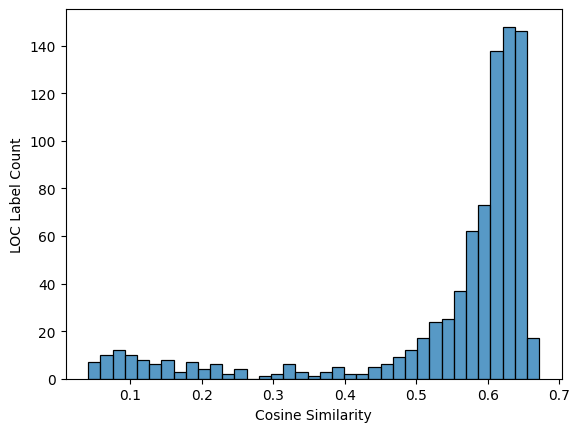

In [61]:
avg_cosine_sim_loc_train_embeddings = embedding_based_similarity_analysis_by_label(train_embeddings, assigned_train_labels_np, 'LOC', hist_plot=True)

In [62]:
(avg_cosine_sim_loc_train_embeddings < 0.2843).sum()

87

Let's review a sample of LOC examples to see if we can identify noisy ones by setting a threshold on the similarity score of our LOC sample of cosine similarity scores.

In [63]:
potential_noisy_sample_loc = get_noisy_sample_for_label(train_model_inputs_and_outputs_df, avg_cosine_sim_loc_train_embeddings, 'LOC', 0.2843)
potential_noisy_sample_loc.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
9,Name the scar-faced bounty hunter of The Old W...,LOC,HUM,4,3,"[0.0445579, 0.16189326, -0.41895902, 0.3701964...","[0.027722329, 0.34004715, 0.018315185, 0.56746...",True
83,What is the nickname for the state of Mississi...,LOC,LOC,4,4,"[0.4519241, 0.10890183, -0.28672463, -0.056986...","[0.04427011, 0.40536994, 0.09779421, 0.1914219...",False
143,What Broadway musical was inspired by Cervante...,LOC,ENTY,4,1,"[0.4193894, -0.84292024, 0.40665817, -0.354631...","[0.026739521, 0.86855525, 0.00905971, 0.040326...",True
224,What is the `` 7-minute cigarette '' ?,LOC,DESC,4,0,"[0.018752156, -0.772527, 0.47138402, -0.735782...","[0.27949107, 0.5412925, 0.09845041, 0.02816174...",True
274,Who was the 16th President of the United States ?,LOC,HUM,4,3,"[-0.4457101, 0.31121433, -0.040484983, 0.38716...","[0.008149092, 0.007535294, 0.010239602, 0.9451...",True
296,What 's the term for a bet before cards are de...,LOC,ENTY,4,1,"[1.0557038, 0.206985, 0.14276098, -0.7789104, ...","[0.13788657, 0.6897821, 0.099693306, 0.0205387...",True
297,"Which came first , according to Genesis 1 : 2 ...",LOC,ENTY,4,1,"[-0.36481383, -0.7901926, 0.50672674, -0.44857...","[0.07901007, 0.6213364, 0.024822094, 0.1547211...",True
529,How many innings are there in a regulation sof...,LOC,NUM,4,5,"[-0.31547952, -0.030651314, -0.10018318, -0.05...","[0.025681492, 0.018831387, 0.008717564, 0.0208...",True
573,What fastener did Whitcomb Judson patent in 18...,LOC,ENTY,4,1,"[-0.06330513, -1.1630298, 0.26775467, 0.360945...","[0.02760054, 0.803337, 0.01613236, 0.11772553,...",True
590,How many hearts does an octopus have ?,LOC,NUM,4,5,"[-0.5083226, 0.1127116, -0.18755774, 0.1005048...","[0.045163155, 0.02844589, 0.011948618, 0.01740...",True


In [64]:
potential_noisy_sample_loc.tail(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4244,What is the difference between a board of dire...,LOC,DESC,4,0,"[-0.6395094, 0.21641949, -0.72537714, -0.29513...","[0.86350614, 0.045593124, 0.024490746, 0.02863...",True
4257,What is SAP ?,LOC,ABBR,4,2,"[-0.6368438, -0.029577889, 0.65080035, -0.1805...","[0.9235892, 0.019432705, 0.035365872, 0.006307...",True
4343,How can I get started in writing for television ?,LOC,DESC,4,0,"[-0.91133285, 0.48271137, -0.20272218, -0.9378...","[0.9256899, 0.02545178, 0.013499911, 0.0119418...",True
4382,What future deer hunter portrayed Annie Hall '...,LOC,HUM,4,3,"[0.0016202, -0.26141298, -0.2837101, -0.185430...","[0.025341941, 0.07661567, 0.019410986, 0.84394...",True
4421,"In Beetle Bailey , can you name Sarge 's dog ?",LOC,ENTY,4,1,"[-0.14408673, -0.37400377, -0.41233003, -0.131...","[0.07045276, 0.7395219, 0.014361239, 0.0715816...",True
4473,Who portrayed the title character in the film ...,LOC,HUM,4,3,"[0.03551458, -0.10099191, -0.30134237, -0.3299...","[0.0075626126, 0.012441837, 0.016034918, 0.938...",True
4531,How was Lawrence,LOC,DESC,4,0,"[-0.9494167, 0.11293344, 0.06890814, -0.840162...","[0.6785202, 0.07047372, 0.04420115, 0.10804412...",True
4533,When did the last Americans leave Vietnam ?,LOC,NUM,4,5,"[-0.9943349, -0.5755235, 0.7629269, -0.8790217...","[0.022159684, 0.019936029, 0.007325768, 0.0188...",True
4535,What group was formed in 1969 after police met...,LOC,HUM,4,3,"[0.32572713, -1.5335916, -0.32176244, -0.58499...","[0.0642305, 0.10653688, 0.04849797, 0.7122003,...",True
4536,Who was Confucius ?,LOC,HUM,4,3,"[0.24180794, 0.71288204, -0.28477314, 0.352559...","[0.045052785, 0.041016623, 0.024003861, 0.8301...",True


The similarity treshold we set is identifying a high number incorrectly marked labels for our 'LOC' sample :)

#### 'NUM' Similarity Score Analysis to Identify Noisy Examples

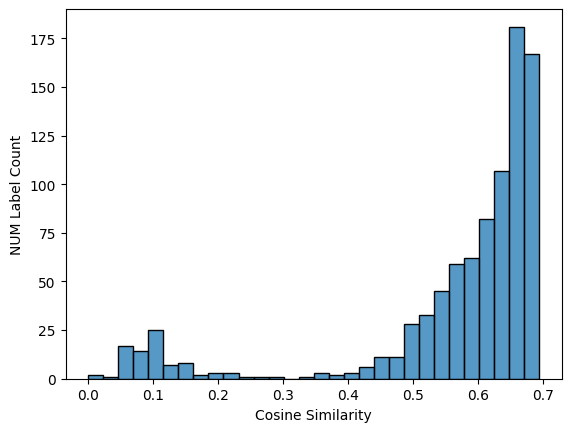

In [65]:
avg_cosine_sim_num_train_embeddings = embedding_based_similarity_analysis_by_label(train_embeddings, assigned_train_labels_np, 'NUM', hist_plot=True)

In [73]:
(avg_cosine_sim_num_train_embeddings < 0.35).sum()

87

Let's review a sample of NUM examples to see if we can identify noisy ones by setting a threshold on the similarity score of our NUM sample of cosine similarity scores.

In [74]:
potential_noisy_sample_num = get_noisy_sample_for_label(train_model_inputs_and_outputs_df, avg_cosine_sim_num_train_embeddings, 'NUM', 0.35)
potential_noisy_sample_num.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
23,What 's the Olympic motto ?,NUM,DESC,5,0,"[0.93213594, 0.32828084, -0.17224836, -0.47141...","[0.25432953, 0.47871602, 0.1127695, 0.09113178...",True
46,What cocktail inspired John Doxat to write the...,NUM,ENTY,5,1,"[0.079030424, -0.1641697, -0.52596915, -0.1355...","[0.02605662, 0.9066136, 0.008371182, 0.0211223...",True
71,Who is the founder of Scientology ?,NUM,HUM,5,3,"[0.1987632, 0.47187164, -0.08511715, 0.1672579...","[0.013186579, 0.009205554, 0.015097746, 0.9311...",True
73,What is the history of skateboarding ?,NUM,DESC,5,0,"[-0.18927634, 0.4126292, -0.27078438, -0.03036...","[0.6807207, 0.14525068, 0.016675781, 0.0319136...",True
131,What is a transistor ?,NUM,DESC,5,0,"[-0.9007625, -0.14591448, 0.016026633, -0.5328...","[0.88479644, 0.034927253, 0.039485667, 0.01608...",True
155,Who was the first American in space ?,NUM,HUM,5,3,"[-0.28437424, 0.33891883, -0.07042613, 0.37149...","[0.009683305, 0.008999661, 0.013871759, 0.9410...",True
181,What game 's board shows the territories of Ir...,NUM,ENTY,5,1,"[-0.7731964, -0.7363961, -0.6115812, 0.0132351...","[0.06743931, 0.77391374, 0.041368376, 0.035428...",True
230,What two European countries entered the War of...,NUM,LOC,5,4,"[0.15529056, -0.6552384, 0.23610072, -0.474893...","[0.036332324, 0.11905362, 0.024965197, 0.41270...",True
309,What is the fastest commercial automobile that...,NUM,ENTY,5,1,"[-0.5930751, -1.1486863, -0.28254184, 0.380985...","[0.022489617, 0.84801984, 0.0159939, 0.0294645...",True
488,What U.S. city is The Queen of the Pacific ?,NUM,LOC,5,4,"[-0.48818392, -0.7893093, -0.07465741, -0.2267...","[0.009117136, 0.012613009, 0.00562952, 0.01546...",True


In [75]:
potential_noisy_sample_num.tail(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4423,Which college did Dikembe Mutombo play basketb...,NUM,HUM,5,3,"[0.56990236, 0.29365113, -0.16873, -0.02071603...","[0.0059951725, 0.025068846, 0.006752843, 0.933...",True
4460,What U.S. state boasts Leif Ericson Park ?,NUM,LOC,5,4,"[-0.8046617, -0.4990445, -0.41970357, 0.215943...","[0.013097541, 0.01661406, 0.009513832, 0.01185...",True
4529,What is a fear of night or darkness ?,NUM,ENTY,5,1,"[0.44166452, -0.61148894, -0.43487296, -0.2706...","[0.016936354, 0.9389943, 0.009902129, 0.010979...",True
4589,What European race sees the winner of its moun...,NUM,ENTY,5,1,"[-0.09420805, -1.0426368, -0.30348358, -0.3882...","[0.05304341, 0.58671165, 0.01693234, 0.1178597...",True
4643,Name an American made motorcycle .,NUM,ENTY,5,1,"[0.4210549, -0.7839185, -0.061436117, 0.116224...","[0.019784864, 0.87816787, 0.012538242, 0.05779...",True
4656,Where 's the Bernini-Bristol Hotel ?,NUM,LOC,5,4,"[-0.24134327, -0.12125845, -0.012968265, -0.79...","[0.033854015, 0.013355936, 0.01124482, 0.01715...",True
4659,What kind of company is 7-Eleven ?,NUM,HUM,5,3,"[1.1943213, -0.012695154, -0.17510428, -0.2126...","[0.02979768, 0.14790972, 0.013486593, 0.769648...",True
4798,What writer is famous for physically putting h...,NUM,HUM,5,3,"[0.29071602, 0.5505649, -0.1947904, -0.4300725...","[0.009032536, 0.011991155, 0.015225377, 0.9400...",True
4812,What daily newspaper will `` help you see clea...,NUM,ENTY,5,1,"[0.3412863, -0.6160043, -0.57222295, 0.2064141...","[0.026126003, 0.7147788, 0.018007092, 0.162216...",True
4826,Where 's Montenegro ?,NUM,LOC,5,4,"[0.6358491, -0.17380074, -0.6444187, 0.3588876...","[0.028442815, 0.0364097, 0.024169698, 0.028310...",True


The similarity treshold we set is identifying a high number incorrectly marked labels for our 'NUM' sample :)

The ease to identify noisy samples using per label embeddings-based similarity approach for 'LOC' and 'NUM' cross checks with our TSNE visualization. The clusters for correctly marked 'LOC' and 'NUM' don't overlap much with other label clusters.

### Aggregate BERT Probabilities Approach

We will now calculate aggregated probabilities for each sample by combining BERT's predicted probabilities. We'll see if we can identify noisy labels with a max or mean aggregation.

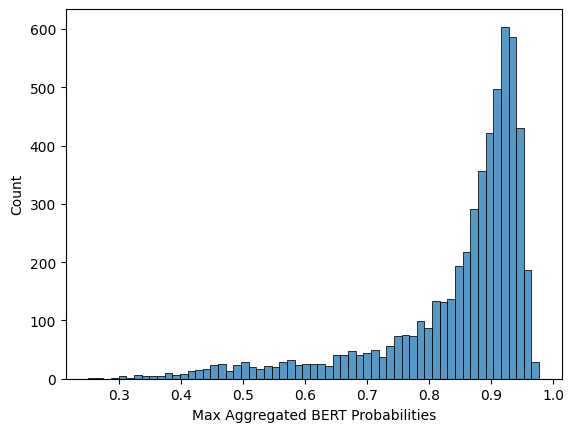

In [76]:
# Get BERT probabilities for our training dataset
train_bert_probabilities = np.vstack(train_model_inputs_and_outputs_df['probs'].tolist())

# Calculate aggregated probabilities for each sample with max first
max_aggregated_probabilities = np.max(train_bert_probabilities, axis=1)  # Use max probability as an example (we can use mean or other aggregation methods)

# Plot Histogram of Max Aggregated Probabilities to Find a Threshold to Identify Noisy Labels
sns.histplot(max_aggregated_probabilities)
_ = plt.xlabel('Max Aggregated BERT Probabilities')

In [77]:
(max_aggregated_probabilities < 0.4).sum()

47

Let's review samples at a threshold of 0.5, 0.4, and 0.3.

In [78]:
potential_noisy_sample_probs_approach = train_model_inputs_and_outputs_df[max_aggregated_probabilities < 0.5]
potential_noisy_sample_probs_approach.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4,What is the full form of .com ?,ABBR,ABBR,2,2,"[0.073927, -0.19951639, 0.9755827, -0.89802194...","[0.27425373, 0.16300455, 0.38139483, 0.1141989...",False
16,What did the only repealed amendment to the U....,DESC,DESC,0,0,"[0.3970012, -0.28372473, -0.40229562, -0.14668...","[0.4197741, 0.45000046, 0.03953341, 0.05077830...",False
18,What is `` Nine Inch Nails '' ?,ABBR,DESC,2,0,"[0.7165188, 0.4860826, 0.4622519, -0.8653039, ...","[0.4924027, 0.24430013, 0.16970195, 0.05698976...",True
23,What 's the Olympic motto ?,NUM,DESC,5,0,"[0.93213594, 0.32828084, -0.17224836, -0.47141...","[0.25432953, 0.47871602, 0.1127695, 0.09113178...",True
39,What relative of the racoon is sometimes known...,ABBR,ENTY,2,1,"[-0.28827932, -0.24717143, 0.3228216, -0.38992...","[0.06786735, 0.3044054, 0.051885817, 0.4423179...",True
83,What is the nickname for the state of Mississi...,LOC,LOC,4,4,"[0.4519241, 0.10890183, -0.28672463, -0.056986...","[0.04427011, 0.40536994, 0.09779421, 0.1914219...",False
92,What are bear and bull markets ?,DESC,DESC,0,0,"[-0.38392696, 0.036142033, -0.42999578, -0.379...","[0.48624116, 0.36987367, 0.021913858, 0.044192...",False
174,On what T.V. show could Tom Terrific be found ?,ENTY,ENTY,1,1,"[0.1711093, -1.1044255, 0.27788654, 0.24514417...","[0.14515501, 0.42564818, 0.024882767, 0.080892...",False
208,What makes hamburgers taste like steakburgers ?,DESC,DESC,0,0,"[-0.021971574, -0.22859003, 0.17859237, 0.0247...","[0.44286624, 0.48274234, 0.030418448, 0.015687...",False
218,What shrubs can be planted that will be safe f...,DESC,ENTY,0,1,"[0.25435123, -0.29952395, 0.33747151, -0.45361...","[0.082897305, 0.46782988, 0.020895252, 0.09331...",True


In [79]:
potential_noisy_sample_probs_approach = train_model_inputs_and_outputs_df[max_aggregated_probabilities < 0.4]
potential_noisy_sample_probs_approach.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4,What is the full form of .com ?,ABBR,ABBR,2,2,"[0.073927, -0.19951639, 0.9755827, -0.89802194...","[0.27425373, 0.16300455, 0.38139483, 0.1141989...",False
268,To what does Microsoft 's Windows 3 owe its su...,ENTY,ENTY,1,1,"[0.18908212, -0.17317079, 0.39672002, 0.070456...","[0.39739192, 0.24829972, 0.0779168, 0.15331809...",False
652,What is the belt of low pressure around the eq...,DESC,ENTY,0,1,"[0.10255277, -0.61918175, 0.8831242, -0.770105...","[0.34191304, 0.24452063, 0.0820303, 0.01981830...",True
718,What is the plural of gulf ?,ENTY,ENTY,1,1,"[0.2318373, 0.025609462, -0.08002964, -0.24840...","[0.39013085, 0.28854927, 0.192771, 0.036621064...",False
834,How do you say 2 in Latin ?,ENTY,ENTY,1,1,"[0.045774244, -0.094779626, -0.069277115, -0.5...","[0.26226157, 0.3712608, 0.26011664, 0.02688861...",False
851,What age followed the Bronze Age ?,LOC,ENTY,4,1,"[0.6359169, 0.041761212, 0.3744885, -0.5224283...","[0.052435216, 0.39428023, 0.035552982, 0.02826...",True
1089,What generation am I in ?,ENTY,ENTY,1,1,"[-0.48265132, -0.6732372, 0.2159019, -1.138246...","[0.1274067, 0.2112994, 0.029247118, 0.21127464...",False
1198,What is the Homelite Inc. home page ?,LOC,LOC,4,4,"[-0.58254254, -0.8031226, -0.24040294, -0.8336...","[0.20122853, 0.30956626, 0.09188341, 0.1712631...",False
1216,What is the highest Roman numeral ?,DESC,DESC,0,0,"[-0.32699823, -0.19680177, 0.1614683, -0.27686...","[0.08370482, 0.39923444, 0.17449605, 0.0488835...",False
1222,What are the first ten amendements passed ?,ENTY,ENTY,1,1,"[-0.39103898, -0.73772746, -0.23756808, -0.706...","[0.18555214, 0.3529095, 0.030016366, 0.0508777...",False


In [80]:
potential_noisy_sample_probs_approach = train_model_inputs_and_outputs_df[max_aggregated_probabilities < 0.3]
potential_noisy_sample_probs_approach.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
2045,What was the nationality of Jackson Pollock ?,LOC,LOC,4,4,"[-0.34327024, -0.43232116, -0.08513691, -0.694...","[0.109919935, 0.26739773, 0.04938797, 0.298164...",False
4326,What is the Homelite Inc. home page ?,ENTY,LOC,1,4,"[-0.7319141, -0.53202516, 0.100697905, -0.7343...","[0.26825508, 0.19116563, 0.078641005, 0.183760...",True
4488,What is the Homelite Inc. home page ?,HUM,LOC,3,4,"[-0.6916167, -0.05419873, 0.3179362, -0.542100...","[0.17722212, 0.12726384, 0.16374223, 0.1724205...",True
4628,What currents affect the area of the Shetland ...,DESC,DESC,0,0,"[0.17834507, -0.8407002, -0.14522657, -0.27342...","[0.23640764, 0.24209425, 0.029458199, 0.049779...",False


In [81]:
potential_noisy_sample_probs_approach = train_model_inputs_and_outputs_df[max_aggregated_probabilities < 0.283]
potential_noisy_sample_probs_approach.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4326,What is the Homelite Inc. home page ?,ENTY,LOC,1,4,"[-0.7319141, -0.53202516, 0.100697905, -0.7343...","[0.26825508, 0.19116563, 0.078641005, 0.183760...",True
4488,What is the Homelite Inc. home page ?,HUM,LOC,3,4,"[-0.6916167, -0.05419873, 0.3179362, -0.542100...","[0.17722212, 0.12726384, 0.16374223, 0.1724205...",True
4628,What currents affect the area of the Shetland ...,DESC,DESC,0,0,"[0.17834507, -0.8407002, -0.14522657, -0.27342...","[0.23640764, 0.24209425, 0.029458199, 0.049779...",False


In these samples, the thresholds set identify a few noisy labels with the risk of falsely marking correctly marked labels as noisy. The max aggregation approach here does not look promising. If we were to leverage it in building a noisy label identification system, we'd have to set the max probability threshold very low. An aggregated probability threshold of 0.283 would be best.

 Let's see if mean aggregation could do better than this.

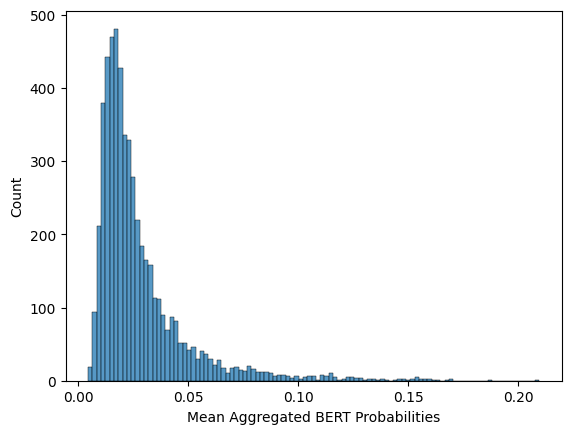

In [82]:
# Calculate aggregated probabilities for each sample with max first
median_aggregated_probabilities = np.median(train_bert_probabilities, axis=1)  # Use median probability

# Plot Histogram of Median Aggregated Probabilities to Find a Threshold to Identify Noisy Labels
sns.histplot(median_aggregated_probabilities)
_ = plt.xlabel('Mean Aggregated BERT Probabilities')

In [83]:
(median_aggregated_probabilities > 0.10).sum()

111

Let's review samples at a threshold of 0.1, 0.15

In [84]:
potential_noisy_sample_probs_approach = train_model_inputs_and_outputs_df[median_aggregated_probabilities > 0.10]
potential_noisy_sample_probs_approach.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
4,What is the full form of .com ?,ABBR,ABBR,2,2,"[0.073927, -0.19951639, 0.9755827, -0.89802194...","[0.27425373, 0.16300455, 0.38139483, 0.1141989...",False
18,What is `` Nine Inch Nails '' ?,ABBR,DESC,2,0,"[0.7165188, 0.4860826, 0.4622519, -0.8653039, ...","[0.4924027, 0.24430013, 0.16970195, 0.05698976...",True
23,What 's the Olympic motto ?,NUM,DESC,5,0,"[0.93213594, 0.32828084, -0.17224836, -0.47141...","[0.25432953, 0.47871602, 0.1127695, 0.09113178...",True
83,What is the nickname for the state of Mississi...,LOC,LOC,4,4,"[0.4519241, 0.10890183, -0.28672463, -0.056986...","[0.04427011, 0.40536994, 0.09779421, 0.1914219...",False
174,On what T.V. show could Tom Terrific be found ?,ENTY,ENTY,1,1,"[0.1711093, -1.1044255, 0.27788654, 0.24514417...","[0.14515501, 0.42564818, 0.024882767, 0.080892...",False
223,What is the daily requirement of folic acid fo...,DESC,DESC,0,0,"[0.3776016, 0.274715, -0.28057674, -0.58061105...","[0.50199956, 0.16015658, 0.03574092, 0.1068192...",False
268,To what does Microsoft 's Windows 3 owe its su...,ENTY,ENTY,1,1,"[0.18908212, -0.17317079, 0.39672002, 0.070456...","[0.39739192, 0.24829972, 0.0779168, 0.15331809...",False
278,What is the lowest level of the American judic...,HUM,ENTY,3,1,"[-0.039560065, -0.04685827, 0.24887708, -0.046...","[0.109325394, 0.12099464, 0.054543603, 0.48530...",True
299,What is Latin for incompetent ?,ENTY,ENTY,1,1,"[1.0725636, 0.3450314, -0.13920003, -0.2765886...","[0.17578731, 0.45443034, 0.27253625, 0.0386768...",False
310,What stadium do the Miami Dolphins play their ...,DESC,LOC,0,4,"[0.85498405, -0.0031502543, 0.17925625, 0.6773...","[0.027076084, 0.26230174, 0.019030176, 0.21632...",True


In [85]:
potential_noisy_sample_probs_approach = train_model_inputs_and_outputs_df[median_aggregated_probabilities > 0.15]
potential_noisy_sample_probs_approach.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
652,What is the belt of low pressure around the eq...,DESC,ENTY,0,1,"[0.10255277, -0.61918175, 0.8831242, -0.770105...","[0.34191304, 0.24452063, 0.0820303, 0.01981830...",True
834,How do you say 2 in Latin ?,ENTY,ENTY,1,1,"[0.045774244, -0.094779626, -0.069277115, -0.5...","[0.26226157, 0.3712608, 0.26011664, 0.02688861...",False
1007,Where did the term `` 86 '' come from ?,DESC,DESC,0,0,"[0.32151264, 0.09554105, 0.3583375, -1.0077368...","[0.45195156, 0.18648078, 0.1536903, 0.02472551...",False
1089,What generation am I in ?,ENTY,ENTY,1,1,"[-0.48265132, -0.6732372, 0.2159019, -1.138246...","[0.1274067, 0.2112994, 0.029247118, 0.21127464...",False
1961,What are the Arabic Numerals from 1 to 10 ?,HUM,DESC,3,0,"[-0.24374273, -0.16660349, -0.03410535, 0.1928...","[0.1775423, 0.18026616, 0.14311846, 0.01342546...",True
2045,What was the nationality of Jackson Pollock ?,LOC,LOC,4,4,"[-0.34327024, -0.43232116, -0.08513691, -0.694...","[0.109919935, 0.26739773, 0.04938797, 0.298164...",False
2139,What was called the world 's largest departmen...,HUM,HUM,3,3,"[0.03533612, -0.21722776, -0.21576697, -0.2035...","[0.028901396, 0.26726514, 0.011877858, 0.33057...",False
2740,What does A&W of root beer fame stand for ?,ABBR,ABBR,2,2,"[-0.3819491, -0.3464258, 0.2794957, 0.21351491...","[0.14998484, 0.15779647, 0.39942703, 0.0502953...",False
2951,What is the HIGHEST Roman numeral ?,HUM,DESC,3,0,"[-0.347082, -0.39911795, 0.53602576, -0.426319...","[0.16584817, 0.30076766, 0.2886226, 0.03090449...",True
3022,What did the Seven Dwarfs do for a living ?,HUM,HUM,3,3,"[1.0665435, 0.20599675, -0.25503302, -1.306590...","[0.3438935, 0.24145055, 0.03681256, 0.2731425,...",False


In [89]:
potential_noisy_sample_probs_approach = train_model_inputs_and_outputs_df[median_aggregated_probabilities > 0.165]
potential_noisy_sample_probs_approach.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
1089,What generation am I in ?,ENTY,ENTY,1,1,"[-0.48265132, -0.6732372, 0.2159019, -1.138246...","[0.1274067, 0.2112994, 0.029247118, 0.21127464...",False
2951,What is the HIGHEST Roman numeral ?,HUM,DESC,3,0,"[-0.347082, -0.39911795, 0.53602576, -0.426319...","[0.16584817, 0.30076766, 0.2886226, 0.03090449...",True
4326,What is the Homelite Inc. home page ?,ENTY,LOC,1,4,"[-0.7319141, -0.53202516, 0.100697905, -0.7343...","[0.26825508, 0.19116563, 0.078641005, 0.183760...",True
4488,What is the Homelite Inc. home page ?,HUM,LOC,3,4,"[-0.6916167, -0.05419873, 0.3179362, -0.542100...","[0.17722212, 0.12726384, 0.16374223, 0.1724205...",True
4628,What currents affect the area of the Shetland ...,DESC,DESC,0,0,"[0.17834507, -0.8407002, -0.14522657, -0.27342...","[0.23640764, 0.24209425, 0.029458199, 0.049779...",False


The median aggregagted appears even worse to identify noisy labels. Such an approach would falsely mark correct samples as noisy.

# Build A Noisy Label Detection System

Using our findings in our embeddings-based similarity noisy label analysis and aggregated BERT probabilities, we will now setup a noisy label detection mainly using the similarity thresholds found in our Per Label Approach to identify noisy samples.

To make a final decision about noisy labels, we will consider both the embedding-based similarity and the aggregated probabilities. We will use a logical OR condition, meaning a sample is considered noisy if either its similarity score or aggregated probabilities indicate noise.

In [108]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict, List, Set

def noisy_label_detection(df: pd.DataFrame, similarity_thresholds_dict: Dict[str, float], probability_threshold: float) -> Dict[str, Set]:
  # Get BERT Embeddings for our dataset df
  bert_embeddings = np.vstack(df['embedding'].tolist())

  # GET BERT Probabilities for our dataset df
  bert_probabilities = np.vstack(df['probs'].tolist())

  # Initialize a dictionary to store potentially noisy sample indices for each label
  labels = similarity_thresholds_dict.keys()
  noisy_sample_indices_per_label = {label: set() for label in labels}

  # Calculate pairwise cosine similarity between BERT embeddings
  cosine_sim_matrix = cosine_similarity(bert_embeddings)

  # Iterate through each label
  for label in labels:
    # Get the indices of samples belonging to the current label
    label_mask = df['label'] == label
    label_indices = df[label_mask].index.values.tolist()

    # Embedding-Based Similarity Noisy Label Detection
    label_similarity_threshold = similarity_thresholds_dict[label]
    ## Iterate through each sample belonging to the current label
    for i in label_indices:
      ## Calculate the average cosine similarity of the current sample with all other samples of the same label
      avg_similarity = np.mean(cosine_sim_matrix[i, label_indices])

      ## Check if the average similarity is below the threshold
      if avg_similarity < label_similarity_threshold:
        noisy_sample_indices_per_label[label].add(i)

    # Aggregated Probailities Noisy Label Detection
    for i in label_indices:
      ## Check if the aggregated probability is below the threshold
      if np.max(bert_probabilities[i]) < probability_threshold:
        noisy_sample_indices_per_label[label].add(i)

  return noisy_sample_indices_per_label

In [109]:
# Similarity Threshold Set for Embeddings-Based Similarity Noisy Label Detection
similarity_thresholds_dict = {'DESC': 0.24, ## Note to reviewer these would need to be reset per rerun of training due to GPU reproducibility issues to ensure maximum precision
                              'ENTY': 0.265,
                              'ABBR': 0.31,
                              'HUM': 0.22,
                              'LOC': 0.2843,
                              'NUM': 0.35}

# Run Our Noisy Detection System to find noisy labels
noisy_sample_indices_per_label = noisy_label_detection(train_model_inputs_and_outputs_df, similarity_thresholds_dict, probability_threshold=0.283)

In [118]:
def get_all_noisy_label_indices(noisy_sample_indices_per_label: Dict[str, Set]):
  all_noisy_label_indices = []

  for label in noisy_sample_indices_per_label:
    label_indices = noisy_sample_indices_per_label[label]
    all_noisy_label_indices.extend(list(label_indices))

  return sorted(all_noisy_label_indices)

In [121]:
# Combine all predictions from dictionary into one master list
pred_noisy_label_indices = get_all_noisy_label_indices(noisy_sample_indices_per_label)

In [122]:
# Get dataframe containing the predicted noisy labels
noisy_labels_mask = train_model_inputs_and_outputs_df.index.isin(pred_noisy_label_indices)
pred_noisy_labels_df = train_model_inputs_and_outputs_df[noisy_labels_mask]
pred_noisy_labels_df.head(20)

,text,label,actual_label,label_idx,actual_label_idx,embedding,probs,incorrect_label
9,Name the scar-faced bounty hunter of The Old W...,LOC,HUM,4,3,"[0.0445579, 0.16189326, -0.41895902, 0.3701964...","[0.027722329, 0.34004715, 0.018315185, 0.56746...",True
23,What 's the Olympic motto ?,NUM,DESC,5,0,"[0.93213594, 0.32828084, -0.17224836, -0.47141...","[0.25432953, 0.47871602, 0.1127695, 0.09113178...",True
29,Which two states enclose Chesapeake Bay ?,DESC,LOC,0,4,"[-0.08608045, -0.42310375, 0.68745136, -0.1892...","[0.03175584, 0.052068625, 0.02243749, 0.129997...",True
39,What relative of the racoon is sometimes known...,ABBR,ENTY,2,1,"[-0.28827932, -0.24717143, 0.3228216, -0.38992...","[0.06786735, 0.3044054, 0.051885817, 0.4423179...",True
46,What cocktail inspired John Doxat to write the...,NUM,ENTY,5,1,"[0.079030424, -0.1641697, -0.52596915, -0.1355...","[0.02605662, 0.9066136, 0.008371182, 0.0211223...",True
47,What ISPs exist in the Caribbean ?,HUM,HUM,3,3,"[0.12477454, -0.17516504, -0.20946446, -0.7678...","[0.5832333, 0.23486756, 0.08695357, 0.0406182,...",False
58,What U.S. state lived under six flags ?,ENTY,LOC,1,4,"[-0.19750294, -1.0054313, 0.12298844, -0.46345...","[0.010597674, 0.03594731, 0.0113803735, 0.1038...",True
64,Who do Herb and Tootsie live next door to ?,ENTY,HUM,1,3,"[0.55685884, 0.5010741, 0.1555125, -0.975122, ...","[0.016624924, 0.013351344, 0.017278818, 0.9243...",True
66,What is a caldera ?,ENTY,DESC,1,0,"[-0.7637394, 0.00907571, 0.6396744, -0.7401673...","[0.86157805, 0.021324769, 0.04288714, 0.013918...",True
70,What body of water does the Danube River flow ...,HUM,LOC,3,4,"[-0.21115622, -0.5660044, -0.2330128, -0.58334...","[0.037501793, 0.03037208, 0.01307052, 0.012637...",True


#### Validate Method

We will validate with two approaches:
 - Evaluate performances metrics such as TPR and FPR.
 - Train a model with the predicted noisy labels removed from the training dataset.

In [123]:
# Get True Noisy Labels and Calculate Number of True Labels
num_true_noisy_labels = train_model_inputs_and_outputs_df['incorrect_label'].sum()
true_noisy_mask = train_model_inputs_and_outputs_df['incorrect_label'] == True
true_noisy_label_indices = train_model_inputs_and_outputs_df[true_noisy_mask].index.values.tolist()

# Get Number of Predicted Labels by Noisy Label Detection System
num_pred_noisy_labels = len(pred_noisy_labels_df)

# Get Number of Correctly Predicted Labels
correctly_predicted_indices = set(true_noisy_label_indices) & set(pred_noisy_label_indices)
num_correctly_predicted = len(correctly_predicted_indices)

# Get Number of Incorrectly Predicted Labels
incorrectly_predicted_indices = set(pred_noisy_label_indices) - set(true_noisy_label_indices)
num_incorrectly_predicted = len(incorrectly_predicted_indices)

print('Numer of True Noisy Labels: {}'.format(num_true_noisy_labels))
print('Number of Predicted Noisy Labels: {}'.format(num_pred_noisy_labels))
print('Number of True Positives: {}'.format(num_correctly_predicted))
print('True Positive Rate (TPR): {}%'.format(num_correctly_predicted / num_true_noisy_labels * 100.0))
print('Number of False Positives: {}'.format(num_incorrectly_predicted))
print('False Positive Rate (FPR): {}'.format(num_incorrectly_predicted / num_true_noisy_labels * 100.0))

Numer of True Noisy Labels: 545
Number of Predicted Noisy Labels: 550
Number of True Positives: 480
True Positive Rate (TPR): 88.07339449541286%
Number of False Positives: 70
False Positive Rate (FPR): 12.844036697247708


In [135]:
# Filter out noisy labels from training dataset
drop_cols = ['embedding', 'probs']
noisy_labels_removed_df = train_model_inputs_and_outputs_df[~noisy_labels_mask].drop(drop_cols, axis=1)

# Convert dataframe to dicts for training model with noisy labels removed
no_noise_train_model_inputs_and_outputs_df = train_df.to_dict("records")
no_noise_test_model_inputs_and_outputs_df = test_df.to_dict("records")

In [136]:
noisy_labels_removed_df.head(20)

,text,label,actual_label,label_idx,actual_label_idx,incorrect_label
0,How did serfdom develop in and then leave Russ...,DESC,DESC,0,0,False
1,What films featured the character Popeye Doyle ?,ENTY,ENTY,1,1,False
2,How can I find a list of celebrities ' real na...,DESC,DESC,0,0,False
3,What fowl grabs the spotlight after the Chines...,ENTY,ENTY,1,1,False
4,What is the full form of .com ?,ABBR,ABBR,2,2,False
5,What contemptible scoundrel stole the cork fro...,HUM,HUM,3,3,False
6,What team did baseball 's St. Louis Browns bec...,HUM,HUM,3,3,False
7,What is the oldest profession ?,HUM,HUM,3,3,False
8,What are liver enzymes ?,DESC,DESC,0,0,False
10,When was Ozzy Osbourne born ?,NUM,NUM,5,5,False


In [137]:
class NoNoiseTextClassificationModel(torch.nn.Module):
    """Defines a Pytorch text classification bert based model."""

    def __init__(self, num_labels: int):
        super().__init__()
        self.feature_extractor = AutoModel.from_pretrained("distilbert-base-uncased")
        self.classifier = Linear(self.feature_extractor.config.hidden_size, num_labels)

    def forward(self, x, attention_mask, ids, split):
        """Model forward function."""
        encoded_layers = self.feature_extractor(
            input_ids=x, attention_mask=attention_mask
        ).last_hidden_state
        classification_embedding = encoded_layers[:, 0]
        logits = self.classifier(classification_embedding)

        probs = F.softmax(logits, dim=-1)

        # TODO: Put outputs somewhere
        for batch_idx, df_idx in enumerate(ids.cpu().detach().numpy()):
            if split == "train":
                no_noise_train_model_inputs_and_outputs_df[df_idx]["embedding"] = classification_embedding[batch_idx].cpu().detach().numpy()
                no_noise_train_model_inputs_and_outputs_df[df_idx]["probs"] = probs[batch_idx].cpu().detach().numpy()
            elif split == "test":
                no_noise_test_model_inputs_and_outputs_df[df_idx]["embedding"] = classification_embedding[batch_idx].cpu().detach().numpy()
                no_noise_test_model_inputs_and_outputs_df[df_idx]["probs"] = probs[batch_idx].cpu().detach().numpy()

        return logits

In [138]:
import random
import torch
import torch.nn.functional as F
import torchmetrics
from tqdm.notebook import tqdm

BATCH_SIZE = 32
NUM_EPOCHS = 3

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_dataset = TextDataset(noisy_labels_removed_df, split="train")
test_dataset = TextDataset(
    test_df,
    split="validation",
    list_of_labels=train_dataset.list_of_labels,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

model = NoNoiseTextClassificationModel(num_labels=len(train_dataset.list_of_labels))
model.to(device)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5
)

train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=len(labels))
val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=len(labels))

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for data in tqdm(train_dataloader):
        x_idxs, x, attention_mask, y = data
        x = x.to(device)
        attention_mask = attention_mask.to(device)
        y = torch.tensor(y, device=device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        logits = model(x, attention_mask, x_idxs, "train")
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_acc(torch.argmax(logits.to("cpu"), 1), y.to("cpu"))

    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        for val_idx, data in tqdm(enumerate(val_dataloader)):
            x_idxs, x, attention_mask, y = data

            x = x.to(device)
            attention_mask = attention_mask.to(device)
            y = torch.tensor(y, device=device)

            logits = model(x, attention_mask, x_idxs, "test")
            loss = F.cross_entropy(logits, y)

            validation_loss += loss.item()
            val_acc(torch.argmax(logits.to("cpu"), 1), y.to("cpu"))

        print(f"Test accuracy: {val_acc.compute()}")

print("Finished Training")

no_noise_train_model_inputs_and_outputs_df = pd.DataFrame(no_noise_train_model_inputs_and_outputs_df)
no_noise_test_model_inputs_and_outputs_df = pd.DataFrame(no_noise_test_model_inputs_and_outputs_df)

  0%|          | 0/154 [00:00<?, ?it/s]

<ipython-input-138-81990cd3d28f>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, device=device)


0it [00:00, ?it/s]

Test accuracy: 0.9599999785423279


<ipython-input-138-81990cd3d28f>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, device=device)


  0%|          | 0/154 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Test accuracy: 0.9639999866485596


  0%|          | 0/154 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Test accuracy: 0.9633333086967468
Finished Training


As we can see in this training run, removing the noisy labels marginally improved our accuracy from 95.6% to 96.3%!

### Further Work
- We can further optimzie the performance of our noisy label detection system with the following approaches:
1. Cross-Validation:
  - Experiment with various similarity threshold values to find the one that results in the best performance in terms of metrics like TPR and FPR.
2. Optimization Algorithm
  - Perform an optimization algorithm such as Bayesian Optimization. We can iterate on our noisy label detection system on thresholds set by the algorithm. We can optimize for a metric such as maximal TPR and the algorithm will automatically find the similarity thresholds.